# Import

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:.3f}'.format)

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import add_dummy_feature

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

RNDM = 1990

# Dataset

In [2]:
# Train dataset
try:
    train = pd.read_csv('https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Jump2digital+2022/train.csv', sep=';')
except:
    train = pd.read_csv('/train.csv', sep=';')
train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
0,-0.458,-0.579,2.886,-0.076,1.674,-2.432,0.535,-0.846,2
1,1.627,-0.028,-1.443,-1.007,-0.989,1.203,-0.038,-1.299,0
2,1.721,-0.138,-1.323,-1.333,-0.724,0.843,-0.588,0.067,0
3,-0.715,3.266,-0.791,-2.968,2.498,-0.277,-0.552,0.668,2
4,2.944,0.198,-2.257,1.033,-4.105,4.716,-0.381,-1.394,0


In [3]:
# Test dataset
try:
    test = pd.read_csv('https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Jump2digital+2022/test.csv', sep=';')
except:
    test = pd.read_csv('test.csv', sep=';')
test.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
0,0.052,2.515,-0.198,1.979,-2.015,3.853,-2.126,0.795
1,-0.828,0.086,1.713,0.079,1.280,-1.462,2.470,0.817
2,-1.086,-0.142,0.013,-0.115,0.948,-1.122,0.517,0.251
3,0.093,2.869,-0.075,0.651,-0.886,2.917,-0.723,0.063
4,0.046,2.823,0.434,-3.055,2.538,-0.717,0.862,-0.525


In [4]:
# Function for checking NaN, Shape and Target-values in train and test
def na0(df):
    return [df.isin([0]).sum().sum(),df.isin([1]).sum().sum(),df.isin([2]).sum().sum(), df.isna().sum().sum(), df.shape]

displ=[]
for df in train, test:
    displ.append(na0(df)) 
pd.DataFrame(displ, columns=['zeros','ones','twos', 'NaN', 'shape'])

,zeros,ones,twos,NaN,shape
0,713,705,682,0,"(2100, 9)"
1,0,0,0,0,"(900, 8)"


In [5]:
# Let's define a function for studying the dataset, we will apply it to different dataframes
def evaluate_df(df, show_corr_zero_plots = False, show_corr_null_plots=False, show_scatter_matrix=False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # number of NaN & zero
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))

    # Statistics
    display(df.describe(include='all').transpose())

    # Distribution
    for feature in df.columns[:-1]:
        _ = sns.histplot(data=df, x=feature, binwidth=0.3)
        plt.show()

In [6]:
df = train.copy()


------SAMPLE--------


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
1168,0.706,0.113,1.333,-0.088,0.085,-0.113,-0.121,-0.080,2
1520,-0.752,-2.465,-0.675,1.263,-0.593,-1.054,-2.276,-0.056,2
428,-0.814,5.530,-1.251,-1.303,0.777,3.118,0.283,-1.237,0
562,-1.640,-2.200,2.043,1.451,1.048,-2.865,-0.052,-2.069,2
551,1.458,-0.790,-0.480,-0.331,-0.974,0.561,-0.090,-0.277,0



------DTYPES--------
feature1    float64
feature2    float64
feature3    float64
feature4    float64
feature5    float64
feature6    float64
feature7    float64
feature8    float64
target        int64
dtype: object


------NaN & zero--------
         NA  filled zero %na
feature1  -    2100    -   -
feature2  -    2100    -   -
feature3  -    2100    -   -
feature4  -    2100    -   -
feature5  -    2100    -   -
feature6  -    2100    -   -
feature7  -    2100    -   -
feature8  -    2100    -   -
target    -    2100  713   -


,count,mean,std,min,25%,50%,75%,max
feature1,2100.000,-0.319,1.575,-5.032,-1.406,-0.431,0.774,5.388
feature2,2100.000,0.005,1.605,-6.005,-1.119,-0.163,1.127,7.663
feature3,2100.000,-0.328,1.480,-5.471,-1.368,-0.532,0.574,4.870
feature4,2100.000,0.024,1.548,-5.296,-1.084,0.153,1.173,4.319
feature5,2100.000,0.086,1.789,-5.719,-1.136,0.103,1.507,6.033
feature6,2100.000,-0.065,2.124,-4.911,-1.613,-0.431,1.163,7.053
feature7,2100.000,-0.026,1.016,-3.851,-0.701,-0.008,0.666,4.401
feature8,2100.000,-0.004,1.003,-3.542,-0.659,-0.020,0.668,3.580
target,2100.000,0.985,0.815,0.000,0.000,1.000,2.000,2.000


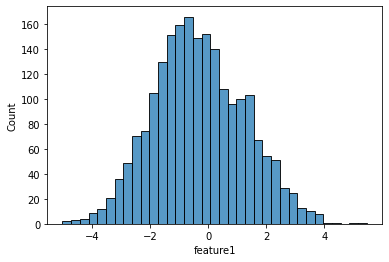

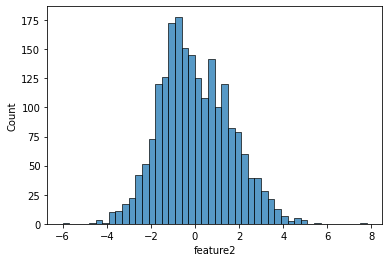

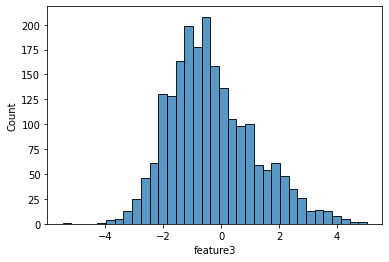

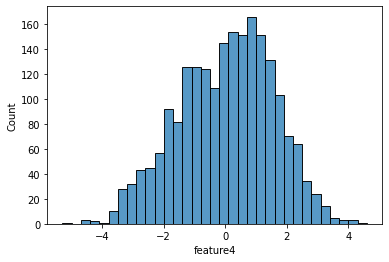

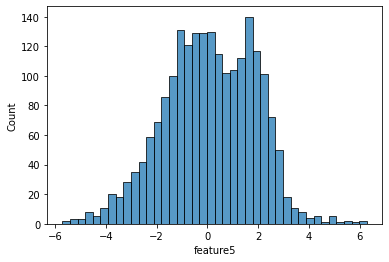

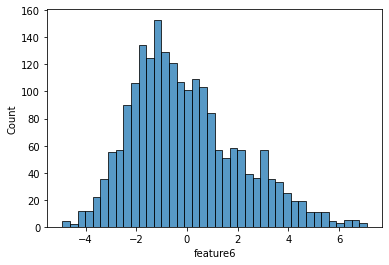

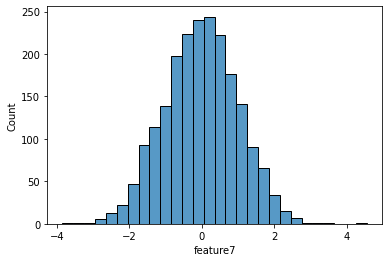

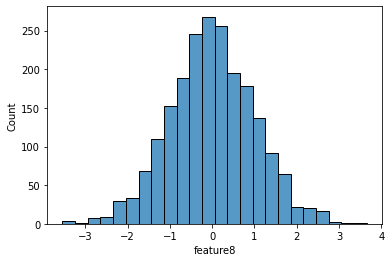

In [7]:
evaluate_df(df)

**Target**

The target is a number, labeled: 0 (good), 1 (moderate), 2 (dangerous)

In [8]:
target = df.groupby('target')['feature1'].count().reset_index()
target

,target,feature1
0,0,713
1,1,705
2,2,682


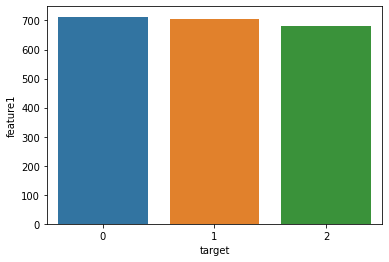

In [9]:
sns.barplot(data=target, x='target', y='feature1')
plt.show()

The target is balanced.

**Features**

## Plots: Target vs Features

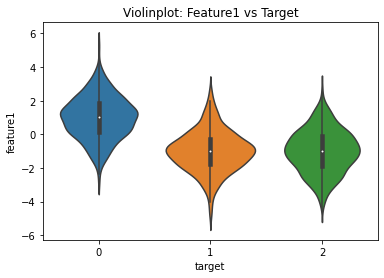

In [10]:
sns.violinplot(data=df, x='target', y='feature1')
plt.title("Violinplot: Feature1 vs Target", fontsize='12')
plt.show()

Feature1: The mean is higher for the target = 0.

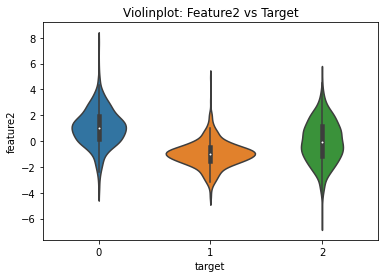

In [11]:
sns.violinplot(data=df, x='target', y='feature2')
plt.title("Violinplot: Feature2 vs Target", fontsize='12')
plt.show()

Feature2: The mean is higher for the target = 0.

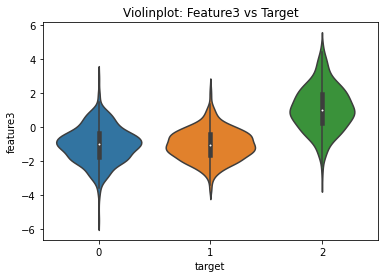

In [12]:
sns.violinplot(data=df, x='target', y='feature3')
plt.title("Violinplot: Feature3 vs Target", fontsize='12')
plt.show()

Feature3: The mean is higher for the target = 2.

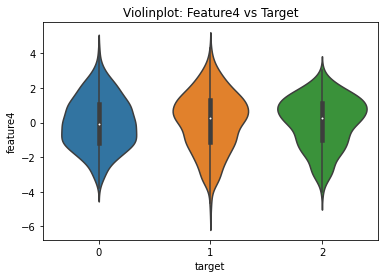

In [13]:
sns.violinplot(data=df, x='target', y='feature4')
plt.title("Violinplot: Feature4 vs Target", fontsize='12')
plt.show()

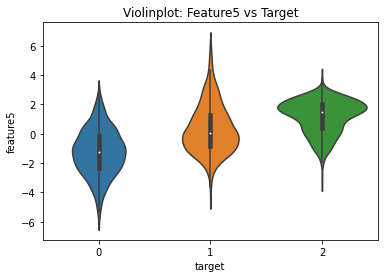

In [14]:
sns.violinplot(data=df, x='target', y='feature5')
plt.title("Violinplot: Feature5 vs Target", fontsize='12')
plt.show()

Feature5: The mean is higher for the target = 2.

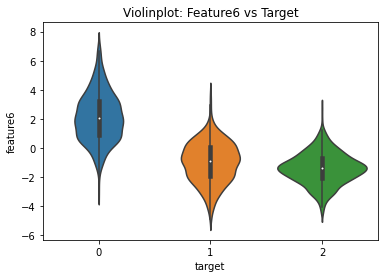

In [15]:
sns.violinplot(data=df, x='target', y='feature6')
plt.title("Violinplot: Feature6 vs Target", fontsize='12')
plt.show()

Feature6: The mean is higher for the target = 0.

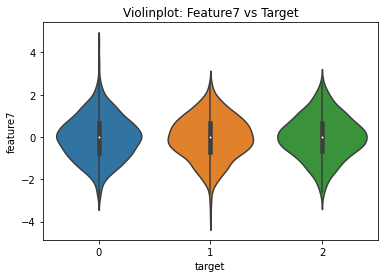

In [16]:
sns.violinplot(data=df, x='target', y='feature7')
plt.title("Violinplot: Feature7 vs Target", fontsize='12')
plt.show()

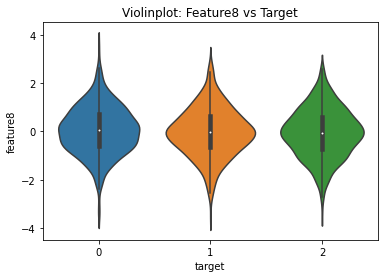

In [17]:
sns.violinplot(data=df, x='target', y='feature8')
plt.title("Violinplot: Feature8 vs Target", fontsize='12')
plt.show()

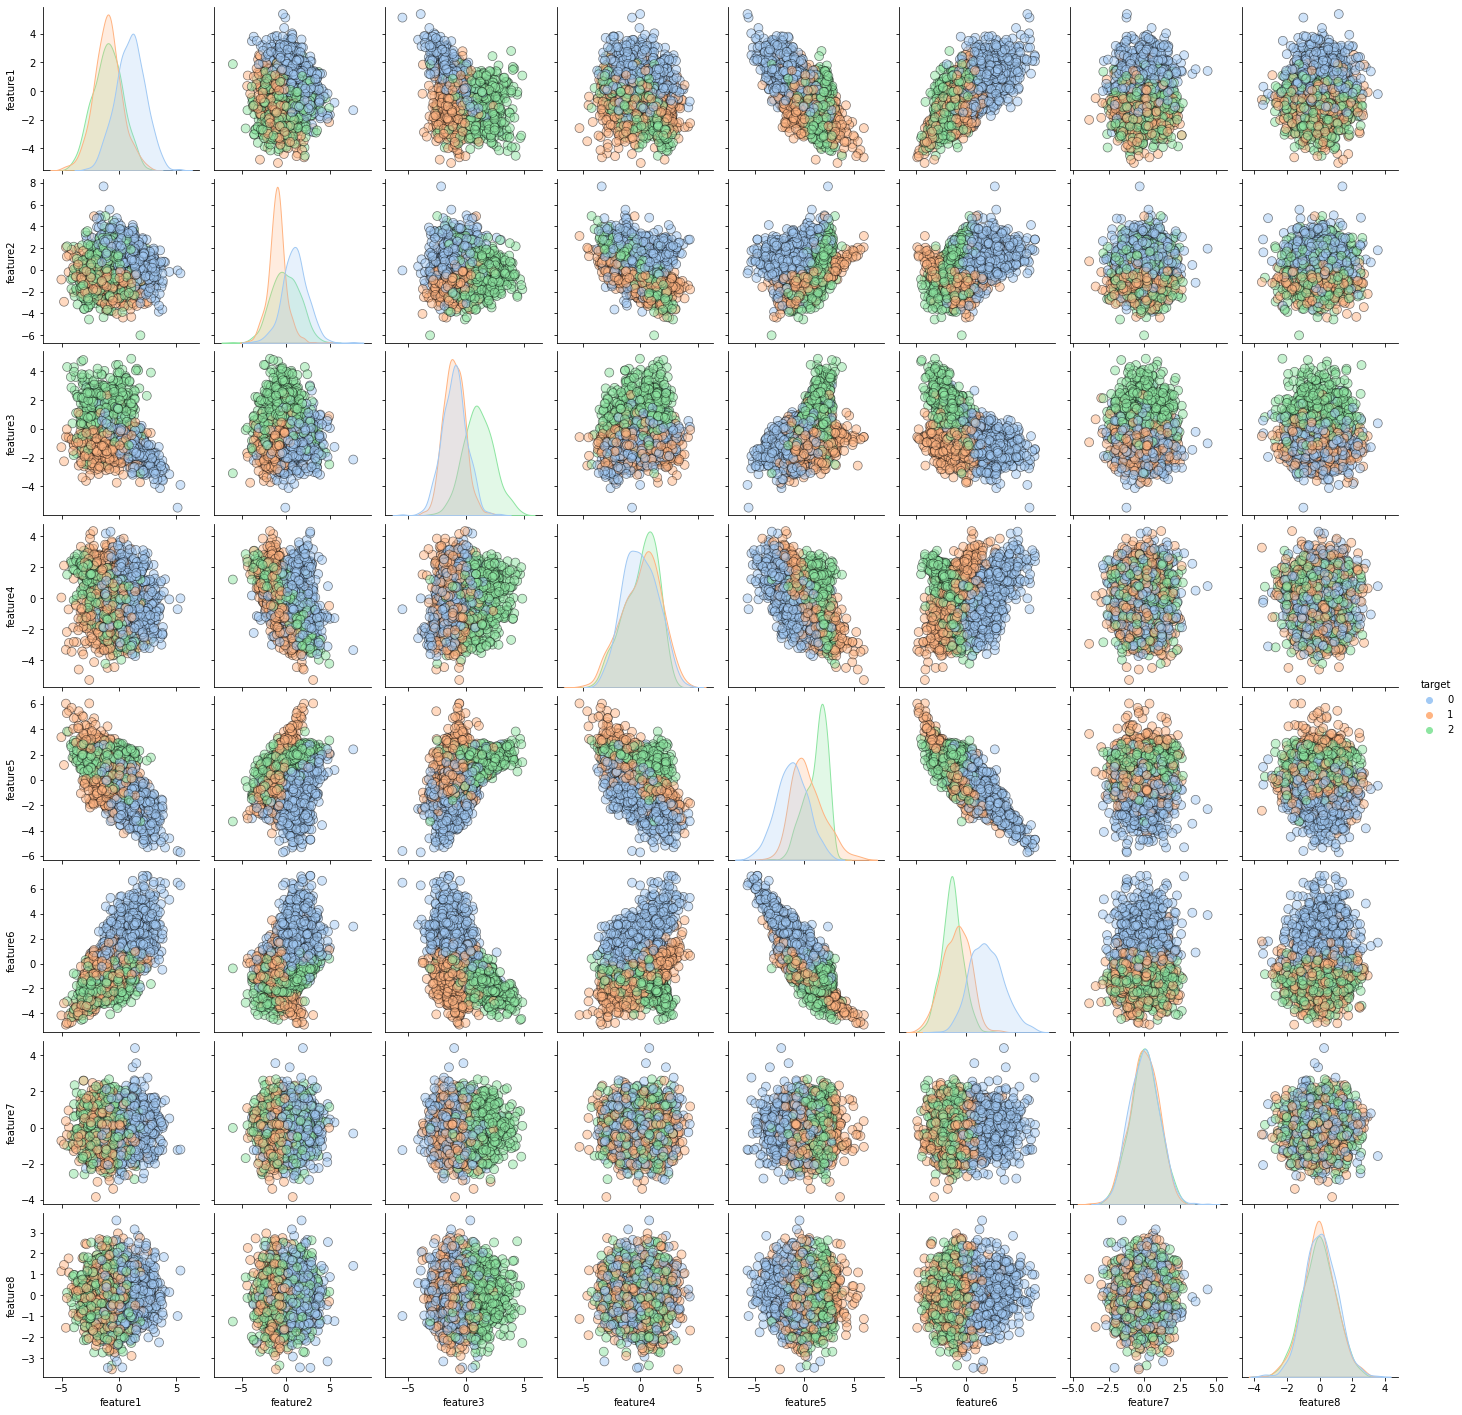

In [18]:
# Pairplots

sns.pairplot(df, hue='target', diag_kind = 'kde', palette='pastel',
             plot_kws = {'alpha': 0.5, 's': 80, 'edgecolor': 'k'})
plt.show()

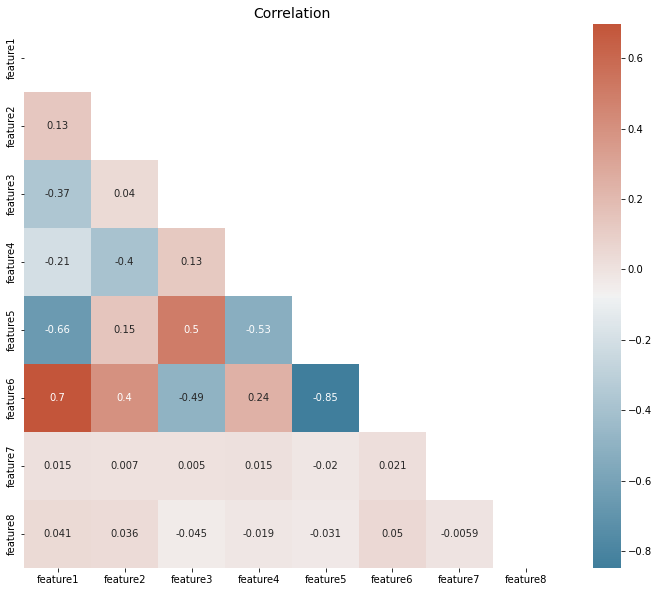

In [19]:
# Correlation

df_corr = df.drop('target', axis=1)
corr = df_corr.corr()

# Set up the matplotlib plot configuration

f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle

mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap

cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap

sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

plt.title("Correlation", fontsize='14')
plt.show()

Correlation between Feature 5 & 6, and Feature 5 & 1 should be checked for multicollinearity.

# Data Preprocessing

In [20]:
# copying train dataset

train_pre = train.copy()

In [21]:
# Train Test Split

X = train_pre.drop(['target'], axis=1)
y = train_pre['target']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RNDM, stratify=y)

In [23]:
features = X.columns
features

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8'], dtype='object')

In [24]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1680
420
1680
420


In [25]:
print(X_train.head(2))
print()
print(X_test.head(2))
print()
print(y_train.head(2))
print()
print(y_test.head(2))

     feature1  feature2  feature3  feature4  feature5  feature6  feature7  feature8
528     3.015    -0.556    -2.649    -1.011    -2.515     2.585    -1.738     0.303
822    -1.406    -1.558     1.375     1.591     0.417    -1.693     0.404     0.807

      feature1  feature2  feature3  feature4  feature5  feature6  feature7  feature8
1330    -0.255    -1.715    -0.935     1.155    -1.050    -0.018     0.436    -0.500
1809     1.432    -0.434    -0.702    -0.697    -0.762     0.607    -0.234    -2.049

528    0
822    2
Name: target, dtype: int64

1330    2
1809    0
Name: target, dtype: int64


**Model: Random Forest**

In [26]:
rf = RandomForestClassifier(random_state = RNDM)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1990)

In [27]:
rf.score(X_train, y_train)

1.0

In [28]:
rf.score(X_test, y_test)

0.8833333333333333

The model is overfitted.

In [29]:
y_pred = rf.predict(X_test)

<AxesSubplot:>

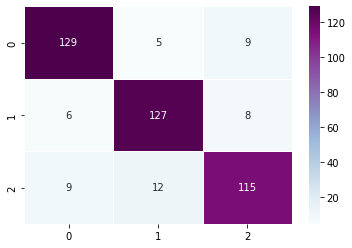

In [30]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g',cmap="BuPu")

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       143
           1       0.88      0.90      0.89       141
           2       0.87      0.85      0.86       136

    accuracy                           0.88       420
   macro avg       0.88      0.88      0.88       420
weighted avg       0.88      0.88      0.88       420



In [32]:
fi = pd.DataFrame([rf.feature_importances_],columns=features)

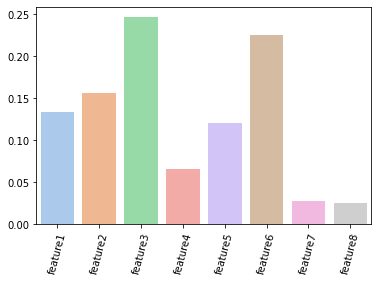

In [33]:
sns.barplot(data=fi, palette="pastel")
plt.xticks(rotation=75)
plt.show()

Most important features: 3 & 6.

# Features

In [34]:
# copying train dataset
train_ftr = train.copy()

In [35]:
len(train_ftr)

2100

In [36]:
train_ftr['dummy'] = np.random.rand(2100)

In [37]:
train_ftr.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target,dummy
0,-0.458,-0.579,2.886,-0.076,1.674,-2.432,0.535,-0.846,2,0.766
1,1.627,-0.028,-1.443,-1.007,-0.989,1.203,-0.038,-1.299,0,0.371
2,1.721,-0.138,-1.323,-1.333,-0.724,0.843,-0.588,0.067,0,0.946
3,-0.715,3.266,-0.791,-2.968,2.498,-0.277,-0.552,0.668,2,0.344
4,2.944,0.198,-2.257,1.033,-4.105,4.716,-0.381,-1.394,0,0.476


In [38]:
X = train_ftr.drop(['target'], axis=1)
y = train_ftr['target']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RNDM, stratify=y)

In [40]:
features = X.columns
features

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'dummy'], dtype='object')

In [41]:
rf = RandomForestClassifier(random_state = RNDM)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1990)

In [42]:
rf.score(X_train, y_train)

1.0

In [43]:
rf.score(X_test, y_test)

0.8904761904761904

In [44]:
y_pred = rf.predict(X_test)

<AxesSubplot:>

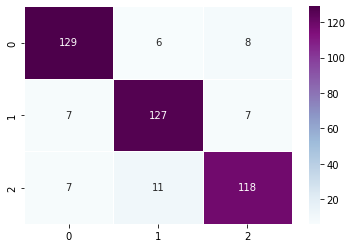

In [45]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g',cmap="BuPu")

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       143
           1       0.88      0.90      0.89       141
           2       0.89      0.87      0.88       136

    accuracy                           0.89       420
   macro avg       0.89      0.89      0.89       420
weighted avg       0.89      0.89      0.89       420



In [47]:
fi = pd.DataFrame([rf.feature_importances_],columns=features)

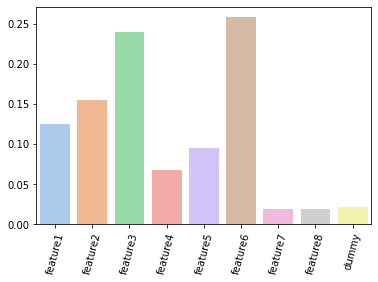

In [48]:
sns.barplot(data=fi, palette="pastel")
plt.xticks(rotation=75)
plt.show()

The most importnant features are the same (3 & 6), however in comparison to `dummy`-feature two features have zero importance and will be removed to reduce noise: **features 7 & 8**.

**Final dataset**

- Highly correlated features (5 & 6)
- Highly important features (3 & 6)
- Least important features (7 & 8)

Based on above, **features 5, 7 & 8 will be removed** from the final dataset. 

However, after some testing, removal of Features 5 makes model worse, so **we keep Feature5**!

In [87]:
# copying train dataset
train_ftr2 = train.copy()

In [88]:
X = train_ftr2.drop(['target','feature7', 'feature8'], axis=1)
y = train_ftr2['target']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RNDM, stratify=y)

In [90]:
features = X.columns
features

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature6'], dtype='object')

In [91]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1680
420
1680
420


In [92]:
print(X_train.head(2))
print()
print(X_test.head(2))
print()
print(y_train.head(2))
print()
print(y_test.head(2))

     feature1  feature2  feature3  feature4  feature6
528     3.015    -0.556    -2.649    -1.011     2.585
822    -1.406    -1.558     1.375     1.591    -1.693

      feature1  feature2  feature3  feature4  feature6
1330    -0.255    -1.715    -0.935     1.155    -0.018
1809     1.432    -0.434    -0.702    -0.697     0.607

528    0
822    2
Name: target, dtype: int64

1330    2
1809    0
Name: target, dtype: int64


**Model: Random Forest**

In [93]:
rf = RandomForestClassifier(random_state = RNDM)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1990)

In [94]:
rf.score(X_train, y_train)

1.0

In [95]:
rf.score(X_test, y_test)

0.888095238095238

In [58]:
y_pred = rf.predict(X_test)

<AxesSubplot:>

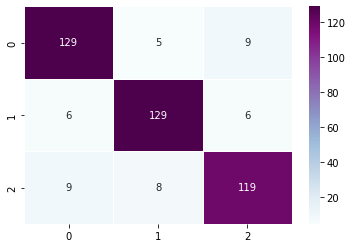

In [59]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g',cmap="BuPu")

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       143
           1       0.91      0.91      0.91       141
           2       0.89      0.88      0.88       136

    accuracy                           0.90       420
   macro avg       0.90      0.90      0.90       420
weighted avg       0.90      0.90      0.90       420



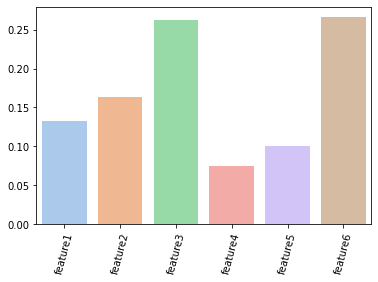

In [61]:
fi = pd.DataFrame([rf.feature_importances_],columns=features)
sns.barplot(data=fi, palette="pastel")
plt.xticks(rotation=75)
plt.show()

# Model Optimization

In [96]:
def scoring_f1(y_test,X_test,method): # generation of f1 macro
    f1score=f1_score(y_test,
                     method.predict(X_test),
                     average= 'macro'
)        
    return f1score

In [63]:
param_test1 = {'n_estimators':[2, 4, 8, 16, 32, 64, 128, 256, 512]
              }
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(random_state = RNDM),
                        param_grid = param_test1, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1990),
             n_jobs=4,
             param_grid={'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256, 512]},
             verbose=4)

In [64]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 256}, 0.9238095238095237)

In [65]:
scoring_f1(y_test,X_test,gsearch1)

0.90196601835425

In [66]:
param_test2 = {'n_estimators':[256], 
               'criterion': ['gini', 'entropy'],
               'max_leaf_nodes': [2**i for i in range(1, 8)]
               }
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(random_state = RNDM),
                        param_grid = param_test2, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch2.fit(X_train,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1990),
             n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128],
                         'n_estimators': [256]},
             verbose=4)

In [67]:
gsearch2.best_params_, gsearch2.best_score_

({'criterion': 'entropy', 'max_leaf_nodes': 128, 'n_estimators': 256},
 0.9238095238095237)

In [68]:
scoring_f1(y_test,X_test,gsearch2)

0.9020686491728203

In [97]:
param_test3 = {'n_estimators':[256], 
               'criterion': ['entropy'],
               'max_leaf_nodes': [128],
               'max_depth': [2, 4, 8, 16, 32, None]
               }
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(random_state = RNDM),
                        param_grid = param_test3, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch3.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1990),
             n_jobs=4,
             param_grid={'criterion': ['entropy'],
                         'max_depth': [2, 4, 8, 16, 32, None],
                         'max_leaf_nodes': [128], 'n_estimators': [256]},
             verbose=4)

In [98]:
gsearch3.best_params_, gsearch3.best_score_

({'criterion': 'entropy',
  'max_depth': 16,
  'max_leaf_nodes': 128,
  'n_estimators': 256},
 0.9184523809523808)

[CV 3/5] END criterion=entropy, max_depth=2, max_leaf_nodes=128, n_estimators=256;, score=0.833 total time=   0.6s
[CV 1/5] END criterion=entropy, max_depth=4, max_leaf_nodes=128, n_estimators=256;, score=0.902 total time=   0.8s
[CV 2/5] END criterion=entropy, max_depth=8, max_leaf_nodes=128, n_estimators=256;, score=0.917 total time=   0.9s
[CV 5/5] END criterion=entropy, max_depth=8, max_leaf_nodes=128, n_estimators=256;, score=0.911 total time=   0.8s
[CV 4/5] END criterion=entropy, max_depth=16, max_leaf_nodes=128, n_estimators=256;, score=0.911 total time=   0.9s
[CV 3/5] END criterion=entropy, max_depth=32, max_leaf_nodes=128, n_estimators=256;, score=0.908 total time=   0.9s
[CV 2/5] END criterion=entropy, max_depth=None, max_leaf_nodes=128, n_estimators=256;, score=0.926 total time=   0.9s
[CV 4/5] END criterion=entropy, max_depth=2, max_leaf_nodes=128, n_estimators=256;, score=0.821 total time=   0.6s
[CV 3/5] END criterion=entropy, max_depth=4, max_leaf_nodes=128, n_estimato

In [71]:
scoring_f1(y_test,X_test,gsearch3)

0.9020686491728203

In [72]:
param_test4 = {'n_estimators':[256], 
               'criterion': ['entropy'],
               'max_leaf_nodes': [128],
               'max_depth': [16],
               'max_features': ["sqrt", "log2", 1, 2, 3, 4, 5, 6],
               'max_samples': [i/10.0 for i in range(1, 10)]
               }
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(random_state = RNDM),
                        param_grid = param_test4, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch4.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1990),
             n_jobs=4,
             param_grid={'criterion': ['entropy'], 'max_depth': [16],
                         'max_features': ['sqrt', 'log2', 1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [128],
                         'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                         0.9],
                         'n_estimators': [256]},
             verbose=4)

In [73]:
gsearch4.best_params_, gsearch4.best_score_

({'criterion': 'entropy',
  'max_depth': 16,
  'max_features': 'sqrt',
  'max_leaf_nodes': 128,
  'max_samples': 0.9,
  'n_estimators': 256},
 0.9238095238095237)

In [74]:
scoring_f1(y_test,X_test,gsearch4)

0.8972550163216709

[CV 1/5] END ....................n_estimators=2;, score=0.857 total time=   0.0s
[CV 2/5] END ....................n_estimators=4;, score=0.905 total time=   0.0s
[CV 1/5] END ....................n_estimators=8;, score=0.908 total time=   0.0s
[CV 5/5] END ....................n_estimators=8;, score=0.896 total time=   0.0s
[CV 4/5] END ...................n_estimators=16;, score=0.899 total time=   0.1s
[CV 3/5] END ...................n_estimators=32;, score=0.905 total time=   0.1s
[CV 2/5] END ...................n_estimators=64;, score=0.917 total time=   0.3s
[CV 1/5] END ..................n_estimators=128;, score=0.932 total time=   0.5s
[CV 5/5] END ..................n_estimators=128;, score=0.932 total time=   0.5s
[CV 4/5] END ..................n_estimators=256;, score=0.917 total time=   0.9s
[CV 3/5] END ..................n_estimators=512;, score=0.911 total time=   1.7s
[CV 2/5] END criterion=gini, max_leaf_nodes=2, n_estimators=256;, score=0.798 total time=   0.7s
[CV 1/5] END

[CV 2/5] END ....................n_estimators=2;, score=0.872 total time=   0.0s
[CV 1/5] END ....................n_estimators=4;, score=0.890 total time=   0.0s
[CV 5/5] END ....................n_estimators=4;, score=0.878 total time=   0.0s
[CV 4/5] END ....................n_estimators=8;, score=0.890 total time=   0.0s
[CV 3/5] END ...................n_estimators=16;, score=0.908 total time=   0.1s
[CV 2/5] END ...................n_estimators=32;, score=0.929 total time=   0.1s
[CV 1/5] END ...................n_estimators=64;, score=0.926 total time=   0.3s
[CV 5/5] END ...................n_estimators=64;, score=0.932 total time=   0.2s
[CV 4/5] END ..................n_estimators=128;, score=0.914 total time=   0.5s
[CV 3/5] END ..................n_estimators=256;, score=0.911 total time=   1.0s
[CV 2/5] END ..................n_estimators=512;, score=0.923 total time=   1.8s
[CV 1/5] END criterion=gini, max_leaf_nodes=2, n_estimators=256;, score=0.815 total time=   0.7s
[CV 5/5] END

[CV 4/5] END ....................n_estimators=2;, score=0.842 total time=   0.0s
[CV 3/5] END ....................n_estimators=4;, score=0.887 total time=   0.0s
[CV 2/5] END ....................n_estimators=8;, score=0.911 total time=   0.0s
[CV 1/5] END ...................n_estimators=16;, score=0.920 total time=   0.1s
[CV 5/5] END ...................n_estimators=16;, score=0.926 total time=   0.1s
[CV 4/5] END ...................n_estimators=32;, score=0.905 total time=   0.1s
[CV 3/5] END ...................n_estimators=64;, score=0.902 total time=   0.3s
[CV 2/5] END ..................n_estimators=128;, score=0.920 total time=   0.5s
[CV 1/5] END ..................n_estimators=256;, score=0.935 total time=   1.0s
[CV 5/5] END ..................n_estimators=256;, score=0.929 total time=   1.0s
[CV 4/5] END ..................n_estimators=512;, score=0.914 total time=   1.7s
[CV 4/5] END criterion=gini, max_leaf_nodes=2, n_estimators=256;, score=0.789 total time=   0.7s
[CV 2/5] END

[CV 3/5] END ....................n_estimators=2;, score=0.827 total time=   0.0s
[CV 5/5] END ....................n_estimators=2;, score=0.848 total time=   0.0s
[CV 4/5] END ....................n_estimators=4;, score=0.872 total time=   0.0s
[CV 3/5] END ....................n_estimators=8;, score=0.890 total time=   0.0s
[CV 2/5] END ...................n_estimators=16;, score=0.914 total time=   0.1s
[CV 1/5] END ...................n_estimators=32;, score=0.926 total time=   0.1s
[CV 5/5] END ...................n_estimators=32;, score=0.932 total time=   0.1s
[CV 4/5] END ...................n_estimators=64;, score=0.917 total time=   0.3s
[CV 3/5] END ..................n_estimators=128;, score=0.911 total time=   0.5s
[CV 2/5] END ..................n_estimators=256;, score=0.929 total time=   1.0s
[CV 1/5] END ..................n_estimators=512;, score=0.940 total time=   1.8s
[CV 5/5] END ..................n_estimators=512;, score=0.929 total time=   1.5s
[CV 3/5] END criterion=gini,

In [75]:
gsearch4.score(X_test, y_test)

0.8976190476190476

In [76]:
y_pred = gsearch4.predict(X_test)

<AxesSubplot:>

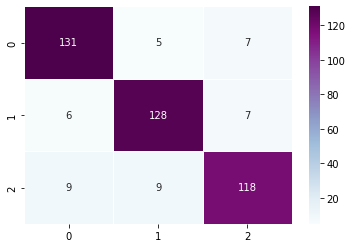

In [84]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g',cmap="BuPu")

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       143
           1       0.90      0.91      0.90       141
           2       0.89      0.87      0.88       136

    accuracy                           0.90       420
   macro avg       0.90      0.90      0.90       420
weighted avg       0.90      0.90      0.90       420



# Prediction

In [80]:
test = test.drop(['feature7', 'feature8'], axis=1)

In [81]:
test.head()

,feature1,feature2,feature3,feature4,feature5,feature6
0,0.052,2.515,-0.198,1.979,-2.015,3.853
1,-0.828,0.086,1.713,0.079,1.280,-1.462
2,-1.086,-0.142,0.013,-0.115,0.948,-1.122
3,0.093,2.869,-0.075,0.651,-0.886,2.917
4,0.046,2.823,0.434,-3.055,2.538,-0.717


In [82]:
prediction = gsearch4.predict(test)

In [83]:
prediction

array([0, 2, 1, 0, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 0,
       1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 1, 0, 1, 1, 2, 1,
       2, 0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 0, 1, 0,
       1, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 0, 0, 2,
       0, 1, 1, 2, 0, 0, 0, 2, 2, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1,
       2, 0, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 2,
       0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 0, 2, 0, 2, 1, 0, 1, 1, 0, 2, 0, 2,
       2, 0, 1, 2, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 1, 2, 2, 0, 2, 2,
       1, 1, 0, 2, 2, 2, 1, 2, 2, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 2, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2,
       2, 0, 1, 0, 0, 0, 1, 2, 1, 2, 1, 2, 1, 0, 0, 1, 1, 2, 1, 2, 0, 2,
       1, 2, 0, 2, 0, 1, 1, 2, 1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 1, 0, 1, 2,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 2, 1,